In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 201 (delta 95), reused 97 (delta 95), pack-reused 102
Receiving objects: 100% (201/201), 576.44 KiB | 217.00 KiB/s, done.
Resolving deltas: 100% (133/133), completed with 15 local objects.
From https://github.com/CSSEGISandData/COVID-19
   fa735795..d1ed7ef3  master     -> origin/master
   a7706dcd..a35c162a  web-data   -> origin/web-data
Updating fa735795..d1ed7ef3
Fast-forward
 .../csse_covid_19_daily_reports/03-27-2020.csv     | 3430 ++++++++++++++++++++
 .../time_series_covid19_confirmed_global.csv       |  499 +--
 .../time_series_covid19_deaths_global.csv          |  499 +--
 .../time_series_covid19_recovered_global.csv       |  471 +--
 4 files changed, 4166 insertions(+), 733 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/03-27-2020.csv


In [3]:
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

#df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [6]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])
    
# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          sigma=np.sqrt(ydata),
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def model_error(xdata, model, pars, cov):
    
    func = lambda pars, args : model(args, *pars)

    eps = np.finfo(np.float16).eps

    err = []
    for x in xdata:
        g = scipy.optimize.approx_fprime(pars, func, eps, x)
        e = np.sqrt(np.dot(g, np.dot(cov,g.T)))
        err.append(e)
        #print(x,popt,g,e)
    
    err=np.array(err)
    return err

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Parameter errors:')
    print(np.sqrt(np.diag(pcov)))
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    #perr = np.sqrt(np.diag(pcov))
    
    forecast = model(index, *popt)
    error = model_error(index, model, popt, pcov)

    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : forecast,
            '1s_sup' : forecast+error,
            '1s_inf' : forecast-error,
            '2s_sup' : forecast+2*error,
            '2s_inf' : forecast-2*error,
            #'Forecast_sup' : model(index, *(popt+perr)),
            #'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df
    
def predict(dates, days, model, popt, pcov):
    
    #perr = np.sqrt(np.diag(pcov))
    
    pred = model(days, *popt)
    error = model_error(days, model, popt, pcov)

    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : pred,
            '1s_sup' : pred+error,
            '1s_inf' : pred-error,
            '2s_sup' : pred+2*error,
            '2s_inf' : pred-2*error,
            #'Model_sup' : model(days, *(popt+perr)),
            #'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df

def plot_model(df_prediction, df_forecast, label='', ax=None, **kwargs):
    # Create axis if none is passed
    if ax == None:
        _,ax = plt.subplots(figsize=(15,15))
    # Provide a default color if none is passed
    if 'color' not in kwargs:
        kwargs['color'] = 'k'    
    # Prediciton
    df_prediction.plot('Date', 'Model', color=kwargs['color'], linestyle='-', alpha=0.5, label=label, ax=ax)
    df_prediction.plot('Date', '1s_sup', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    df_prediction.plot('Date', '1s_inf', color=kwargs['color'], linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
    # Forecast
    df_forecast.plot('Date', 'Forecast', color=kwargs['color'], linestyle='--', alpha=0.5, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '1s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_sup', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    df_forecast.plot('Date', '2s_inf', color=kwargs['color'], linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
    ax.fill_between(df_forecast['Date'], df_forecast['1s_inf'], df_forecast['1s_sup'], facecolor=kwargs['color'], alpha=0.1)
    ax.fill_between(df_forecast['Date'], df_forecast['2s_inf'], df_forecast['2s_sup'], facecolor=kwargs['color'], alpha=0.1)

# Fit data for Italy

In [7]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

# Stop the fit 3 days ago. Use the last 3 point to verify (qualitatively) the fit prediction power.
ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[-4.76730302e+02,1.72669390e-01,6.13355554e+00]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-1.45642707e+03  1.35528421e-01  7.21127473e+00]

Parameter errors:
[2.13835094e+02 3.94838403e-03 1.04752779e-01]

Covariance matrix:
[[ 4.57254475e+04  7.45779335e-01 -2.04049676e+01]
 [ 7.45779335e-01  1.55897365e-05 -4.07277571e-04]
 [-2.04049676e+01 -4.07277571e-04  1.09731447e-02]]

R-square: 0.698

-----------------
Logistic model
-----------------

Fit Parameters:
[-4.45505030e+02  1.15495949e+05  1.92579042e-01  2.78185013e+01]

Parameter errors:
[4.97818652e+01 4.38552805e+03 3.12601840e-03 3.72852894e-01]

Covariance matrix:
[[ 2.47823410e+03 -1.44695130e+05  1.31547763e-01 -1.27021377e+01]
 [-1.44695130e+05  1.92328563e+07 -1.22447834e+01  1.62000143e+03]
 [ 1.31547763e-01 -1.22447834e+01  9.77199104e-06 -1.07850198e-03]
 [-1.27021377e+01  1.62000143e+03 -1.07850198e-03  1.39019281e-01]]

R-square: 0.987


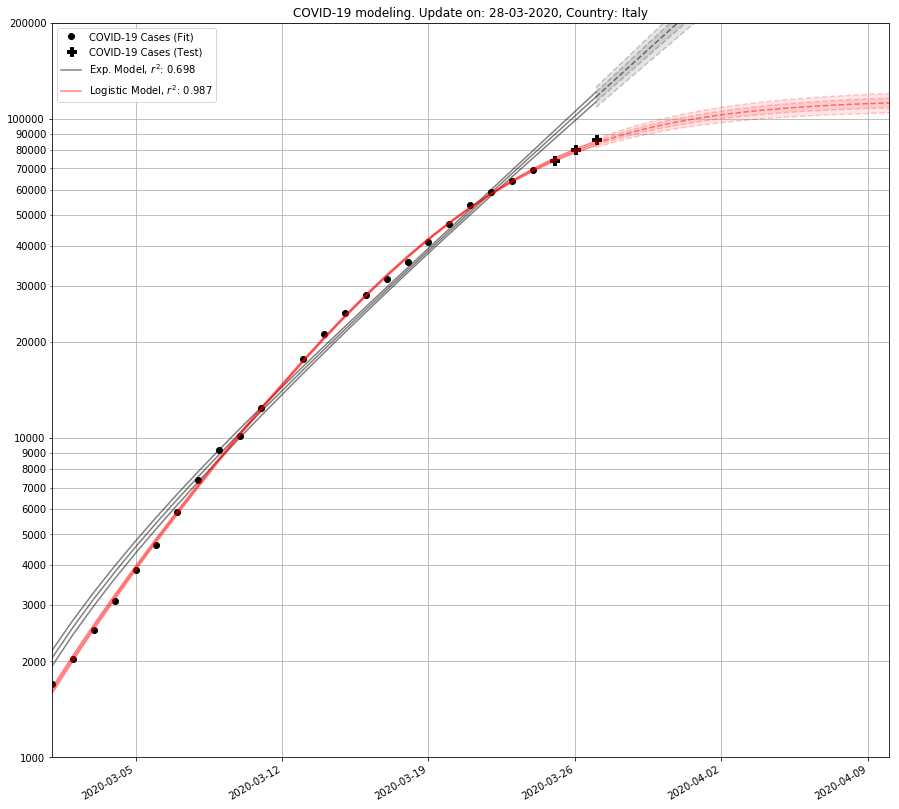

In [8]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

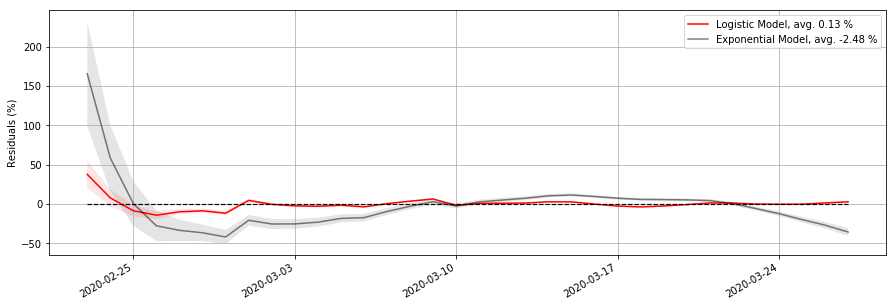

In [9]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

## Logistic model: forecast 30 days ahead

In [10]:
display(df_forecast_logit)

,Date,Forecast,1s_sup,1s_inf,2s_sup,2s_inf,Uncertainty
33,2020-03-27,83939.908829,85221.517713,82658.299944,86503.126598,81376.691059,1281.608885
34,2020-03-28,88118.803007,89668.175598,86569.430416,91217.548189,85020.057825,1549.372591
35,2020-03-29,91890.429909,93711.167998,90069.691821,95531.906086,88248.953733,1820.738088
36,2020-03-30,95251.939196,97339.858962,93164.019429,99427.778729,91076.099662,2087.919767
37,2020-03-31,98214.509915,100559.134143,95869.885688,102903.758370,93525.261460,2344.624228
38,2020-04-01,100799.787687,103385.960032,98213.615342,105972.132377,95627.442998,2586.172345
39,2020-04-02,103036.419602,105845.867959,100226.971245,108655.316316,97417.522888,2809.448357
40,2020-04-03,104957.009472,107969.733124,101944.285819,110982.456776,98931.562167,3012.723652
41,2020-04-04,106595.654659,109791.066641,103400.242678,112986.478622,100204.830696,3195.411981
42,2020-04-05,107986.099693,111343.903555,104628.295831,114701.707417,101270.491969,3357.803862


## Fit stability
### Logistic model

In [11]:
#dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
#dfit = dfit.loc[dfit['Cases'] > 10]

#dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

#ydata=dfit['Cases'] 
#xdata=dfit['ndays']

#p0=popt
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]

fit_stab = []

for i in range(len(xdata))[::-1]:
    
    if i != 0:
        
        ipopt, ipcov, irsquare = fit_model(xdata[:i],ydata[:i],logistic_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : ipopt, 
            'perr' : np.sqrt(np.diag(ipcov)), 
            'r_square' : irsquare
        })

In [12]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2', 'popt_3']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2', 'perr_3']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

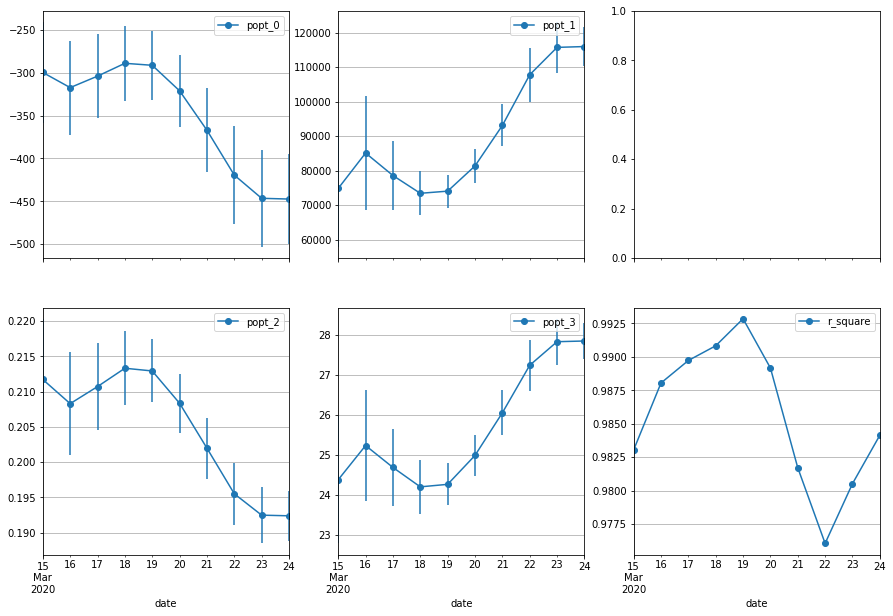

In [13]:
f, ax = plt.subplots(2, 3, sharex=True, figsize=(15,10))

df[-10:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
df[-10:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
df[-10:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
df[-10:].plot(x='date', y='popt_3', yerr='perr_3', marker='o', grid=True, ax=ax[1][1])
df[-10:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][2])

#plt.xlabel('')

plt.show()

### Exponential model

In [14]:
#dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
#dfit = dfit.loc[dfit['Cases'] > 10]

#dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

#ydata=dfit['Cases'] 
#xdata=dfit['ndays']

p0=[-4.76730302e+02,1.72669390e-01,6.13355554e+00]

fit_stab = []

for i in range(len(xdata)):#[::-1]:
    
    if i != 0:
            
        ipopt, ipcov, irsquare = fit_model(xdata[:i],ydata[:i],exponential_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : ipopt, 
            'perr' : np.sqrt(np.diag(ipcov)), 
            'r_square' : irsquare
        })

In [15]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

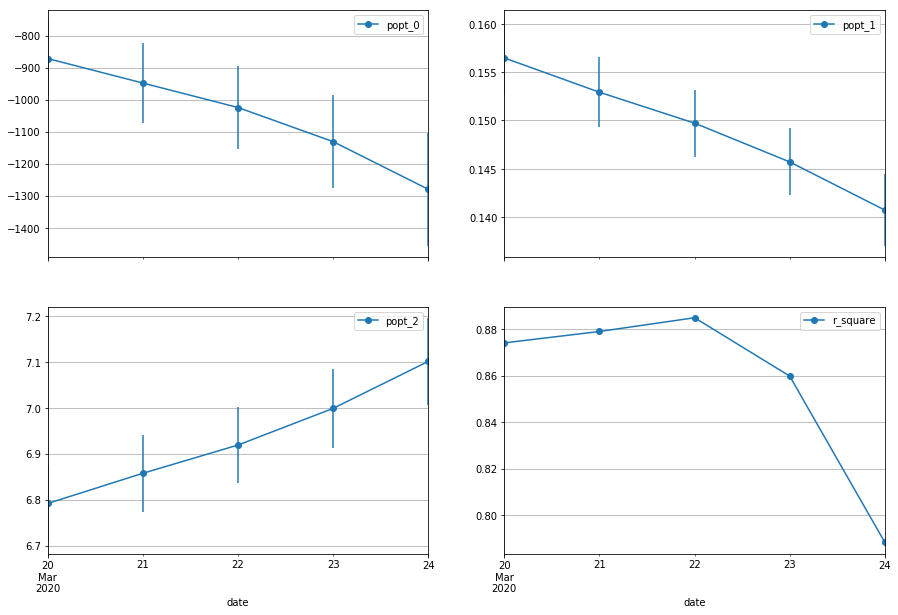

In [16]:
f, ax = plt.subplots(2, 2, sharex=True, figsize=(15,10))

df[-5:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
df[-5:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
df[-5:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
df[-5:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][1])

#plt.xlabel('')

plt.show()

# Fit data for France

In [17]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'France'].reset_index(drop=True)

# Drop 15/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(52, axis=0)

dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-5.65317705e+02  1.62306247e-01  6.36578567e+00]

Parameter errors:
[9.40455061e+01 5.16852361e-03 1.07498409e-01]

Covariance matrix:
[[ 8.84455722e+03  4.37814672e-01 -9.36927421e+00]
 [ 4.37814672e-01  2.67136363e-05 -5.48455569e-04]
 [-9.36927421e+00 -5.48455569e-04  1.15559078e-02]]

R-square: 0.916

-----------------
Logistic model
-----------------

Fit Parameters:
[-2.20945532e+02  4.67007924e+04  2.15050966e-01  2.34126704e+01]

Parameter errors:
[6.43319503e+01 6.70365382e+03 1.02316938e-02 1.15244287e+00]

Covariance matrix:
[[ 4.13859983e+03 -3.12337127e+05  5.85675965e-01 -5.55231890e+01]
 [-3.12337127e+05  4.49389746e+07 -6.28641465e+01  7.68926567e+03]
 [ 5.85675965e-01 -6.28641465e+01  1.04687559e-04 -1.11001677e-02]
 [-5.55231890e+01  7.68926567e+03 -1.11001677e-02  1.32812458e+00]]

R-square: 0.958


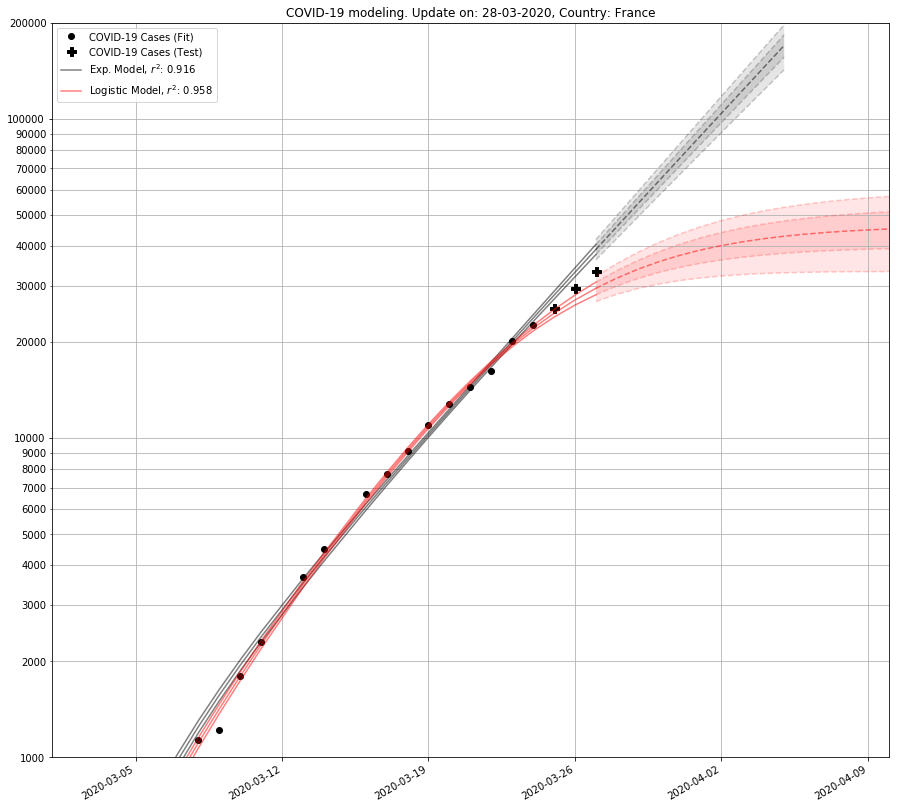

In [18]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

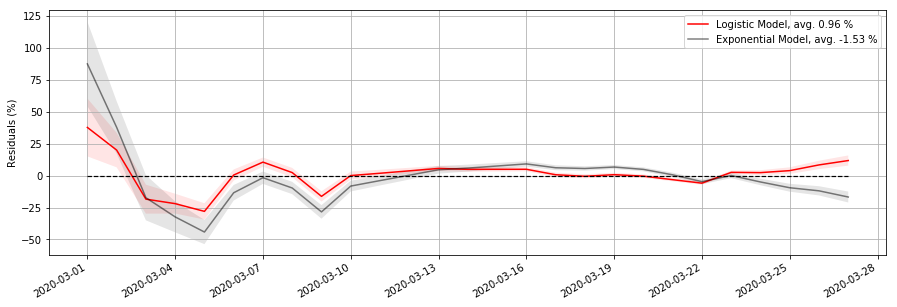

In [19]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()

# Fit data for Switzerland

In [20]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Switzerland'].reset_index(drop=True)

# Drop 16/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(53, axis=0)

dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'][:-3]
xdata=dfit['ndays'][:-3]

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-94.43780867   0.1984623    4.53443501]

Parameter errors:
[2.08395329e+01 5.81727493e-03 1.24317465e-01]

Covariance matrix:
[[ 4.34286131e+02  9.97303017e-02 -2.19463429e+00]
 [ 9.97303017e-02  3.38406876e-05 -7.13629906e-04]
 [-2.19463429e+00 -7.13629906e-04  1.54548321e-02]]

R-square: 0.796

-----------------
Logistic model
-----------------

Fit Parameters:
[-3.50359754e+01  2.33625437e+04  2.45702447e-01  2.50966847e+01]

Parameter errors:
[1.58533454e+01 4.47426729e+03 1.18959978e-02 1.28609982e+00]

Covariance matrix:
[[ 2.51328561e+02 -4.58342402e+04  1.55155357e-01 -1.38414525e+01]
 [-4.58342402e+04  2.00190678e+07 -4.77478411e+01  5.72100346e+03]
 [ 1.55155357e-01 -4.77478411e+01  1.41514764e-04 -1.42377829e-02]
 [-1.38414525e+01  5.72100346e+03 -1.42377829e-02  1.65405274e+00]]

R-square: 0.935


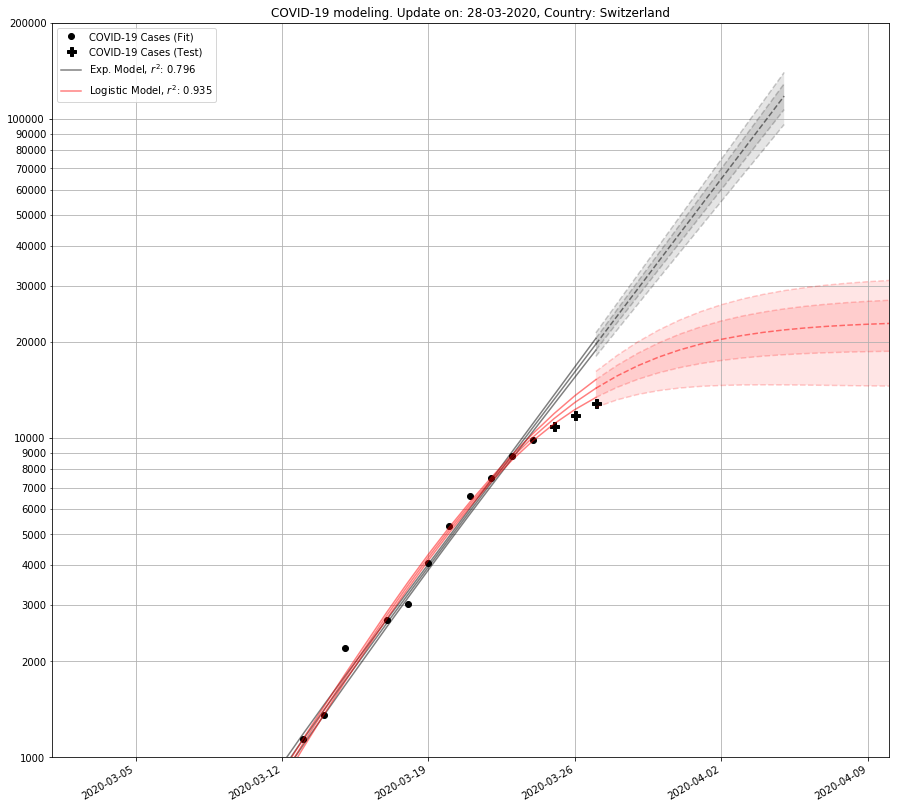

In [21]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit[:-3].plot('Date', 'Cases', marker='o', color='k', linestyle="None", label='COVID-19 Cases (Fit)', ax=ax, logy=logy)
dfit[-3:].plot('Date', 'Cases', marker='P', color='k', ms=9, linestyle="None", label='COVID-19 Cases (Test)', ax=ax)

# Exponential Model
plot_model(df_predict_exp, df_forecast_exp, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax, color='k')
# Logistic Model
plot_model(df_predict_logit, df_forecast_logit, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax, color='r')

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 200000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

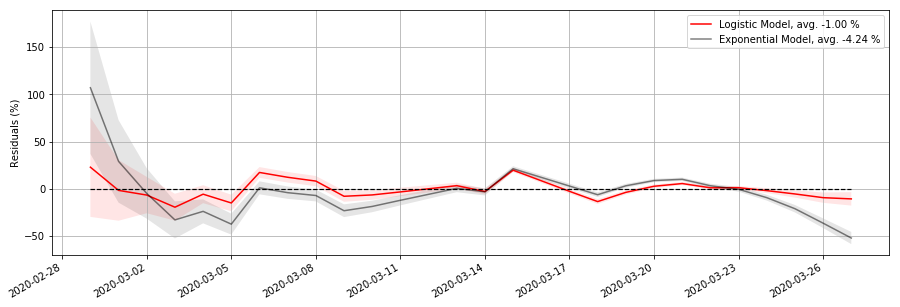

In [22]:
res=dfit.merge(df_predict_logit, on='Date')
res['res'] = res['Cases'] - res['Model']
res['rres'] = 100*res['res'] / res['Cases']
res['eres'] = 100*res['Uncertainty'] / res['Cases']

res_exp=dfit.merge(df_predict_exp, on='Date')
res_exp['res'] = res_exp['Cases'] - res_exp['Model']
res_exp['rres'] = 100*res_exp['res'] / res_exp['Cases']
res_exp['eres'] = 100*res_exp['Uncertainty'] / res_exp['Cases']

mean_res = np.mean(res.rres)
mean_res_exp = np.mean(res_exp.rres)


_,ax = plt.subplots(figsize=(15,5))

res.plot('Date', 'rres', color='red', 
         label='Logistic Model, avg. %.2f %%' % mean_res, ax=ax)
ax.fill_between(res['Date'], 
                res['rres']-res['eres'], 
                res['rres']+res['eres'], facecolor="red", alpha=0.1)

res_exp.plot('Date', 'rres', color='k', alpha=0.5, 
             label='Exponential Model, avg. %.2f %%' % mean_res_exp, ax=ax)
ax.fill_between(res_exp['Date'], 
                res_exp['rres']-res_exp['eres'], 
                res_exp['rres']+res_exp['eres'], facecolor="k", alpha=0.1)


ax.plot(res.Date, [0]*len(res), 
        color='k', linestyle='--', linewidth=1.2,
       label='')

plt.legend()
plt.grid(axis='both',which='both')
plt.ylabel('Residuals (%)')
plt.xlabel('')
plt.show()